<a href="https://colab.research.google.com/github/valerio98-lab/sdg4ad_AnomalyGeneration/blob/main/Bug_Free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SET_UP, LIBRERIE E FUNZIONI NECESSARIE

In [ ]:
"""
TODO:
- Completare i parametri d'ingresso
- Analizzare la dipendenza tra ridimensionamento e min_mask_region
- Quali sono i migliori valori per min_mask e max_mask?
- Possibilità di utilizzare più di un'immagine danneggiata
- Risolvere il warning sul clipping
"""

"""
DONE:
- Risolto l'OutOfMem
- Risolto istanziamento multiplo di SAM
- Introdotto il ridimensionamento delle immagini prima di essere processate
- Ridotti gli artefatti e migliorata la segmentazione di SAM
- Introduzione di una funzione per la gestione dell'area minima della maschera
- Modificata la gestione dei bordi della warpAffine per riduzione bordi neri
"""

In [144]:
#Segmentazione degli acini cattivi e visualizzazione di quest'ultimi. Se manual_mode = True scegliere il numero dell'acino (o acini) che si vogliono utilizzare
#Se si vuole modificare più di un acino sano con lo stesso danneggiato inserire più volte il numero dell'acino danneggiato.
manual_mode = True
using_colab = True
dest_path = '/content/final'

target_height=1440            #Risoluzione verticale ed orizzontale per il ridimensionamento delle immagini. Più è alto più RAM servirà.
target_width=2650

#Se generate grapes = False salverà in new_grapes gli acini sani modificati in danneggiati, se invece è True genererà e salverà l'intero grappolo
generate_grapes = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import time
import os
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from sklearn.decomposition import PCA
import imageio
import cv2
from google.colab.patches import cv2_imshow
import random

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-k_map0dp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-k_map0dp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=afba8d87bddf6111d39c5fe8c97817bcc6ca3b55e6b66e43cd66fa52c3582937
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_vwysvo/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-02-16 09:22:27--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.142.40, 108.157.142.74

## UTILS -> SHOW MASKS AND IMAGES.

In [93]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_image(image, title):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(image)
    plt.axis('on')
    plt.show()

def show_images_plus_mask(img, mask):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_anns(mask)
    plt.axis('on')
    plt.show()

import matplotlib.pyplot as plt

def show_a_bunch_of_images(image_list):
  num_img = len(image_list)

  fig, axes = plt.subplots(1, num_img, figsize=(15,5))

  for ax, img in zip(axes, image_list):
      ax.imshow(img)
      ax.axis('on')

def show_a_bunch_of_selection(image_list):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for idx, (ax, img) in enumerate(zip(axes.ravel(), image_list)):
        ax.imshow(img)
        ax.set_title(f"Maschera {idx+1}-esima")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def show_two_images(img1, img2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(img1)
    ax1.set_title("Prima immagine")
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title("Seconda immagine")
    ax2.axis('off')

def resize_image(image_path, target_height, target_width):

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    aspect_ratio = width / height
    target_ratio = target_width / target_height

    if aspect_ratio > target_ratio:
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_image


##UTILS -> MAIN FUNCTIONS

In [134]:
def mask_generator_process(types, image, mask_generator, manual_mode, num_choice):
  if(types=="bad"):
    print("bad")
    masks = mask_generator.generate(image)
    show_images_plus_mask(image, masks)
    mask_sorted = sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
    selected_mask = []
    if(manual_mode==False):
      len_sorted = len(mask_sorted) if (len(mask_sorted)<4) else 4
    else:
      len_sorted = len(mask_sorted) #if (len(mask_sorted)<7) else 7
    for i in range(len_sorted):
      #random_num = random.randint(0, len_sorted)
      selected_mask.append(mask_sorted[i]['segmentation'])
    #show_a_bunch_of_selection(selected_mask)

  if(types=="good"):
    print("good")
    if manual_mode:
      index = num_choice
    else: index = 4
    masks = mask_generator.generate(image)
    masks = filter_masks_by_area(masks)
    #show_images_plus_mask(image_good, masks)
    mask_sorted = sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
    len_sorted = len(mask_sorted)
    selected_mask = []
    takes = []
    random_num = random.randint(0, (len_sorted-1))
    i=0
    print("Lunghezza maschera ordinata: ",len_sorted)
    while(i!=index):
      if(random_num not in takes):
        takes.append(random_num)
        print("Numero randomico estratoo: ", random_num)
        selected_mask.append(mask_sorted[random_num]['segmentation'])
        #random_num = random.randint(0, (len_sorted-1))
        i+=1
      random_num = random.randint(0, (len_sorted-1))
    #show_a_bunch_of_images(selected_mask)
    #print("Exit")
  return selected_mask

def filter_masks_by_area(masks):
  print("Numero maschere predette prima del filtraggio per area: ", len(masks))
  new_masks = []
  for elem in masks:
    if elem['area'] > min_mask_region_area and elem['area'] < max_mask_region_area:
      new_masks.append(elem)

  print("Numero maschere rimanenti dopo il filtraggio per area: ", len(new_masks))
  return new_masks



def find_grade(rows_mask, cols_mask):
    y = rows_mask
    x = cols_mask
    coords = np.column_stack((x, y))

    pca = PCA(n_components=2)
    pca.fit(coords)

    angle_rad = np.arctan2(pca.components_[0, 1], pca.components_[0, 0])
    angle_degrees = np.degrees(angle_rad)
    return angle_degrees

def turn_the_grape(bad_grape, rows_mask_bad, cols_mask_bad, rows_mask_good, cols_mask_good):
    bad_angle = find_grade(rows_mask_bad, cols_mask_bad)
    good_angle = find_grade(rows_mask_good, cols_mask_good)
    center = (bad_grape.shape[1] // 2, bad_grape.shape[0] // 2)

    theta = good_angle - bad_angle
    matrix = cv2.getRotationMatrix2D(center, -theta, 1)
    bad_grape_rotated = cv2.warpAffine(bad_grape, matrix, (bad_grape.shape[1], bad_grape.shape[0]),
    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return bad_grape_rotated

def PoissonBlending(source, destination, mask_buona, cloning_type): #blending_mask):
  # bldnding_mask è un parametro non attualmente utilizzato
  mask = 255 * np.ones(destination.shape, destination.dtype)

  width, height, channels = source.shape
  center = (height//2, width//2)

  blended = cv2.seamlessClone(destination, source, mask, center, cloning_type) # cv::MIXED_CLONE = 2
  #imageio.imsave("blending.png", blended)
  #img = cv2.imread("blending.png")
  #show_image(blended, "Blended images")
  return blended

def xor_mask(submatrix_good, mask_cattiva):
  mask_dark = submatrix_good * (1 - mask_cattiva)
  plt.imshow(mask_dark), mask_cattiva.shape
  mask_dark_32f = mask_dark.astype(np.float32)
  grayscale_mask = cv2.cvtColor(mask_dark_32f, cv2.COLOR_BGR2GRAY)
  dark_mask_bool = grayscale_mask > 0
  #plt.imshow(dark_mask_bool)
  return dark_mask_bool

def light_correct(blended, bad_image_cropped_resized, good_image_cropped, mask_cattiva, types, en, combined):
  acino_danneggiato_float = bad_image_cropped_resized.astype(np.float32) / 255.0
  acino_sano_float = good_image_cropped.astype(np.float32) / 255.0
  acino_combined_float = blended.astype(np.float32) / 255.0

  intensity_bad = np.mean(acino_danneggiato_float)
  intensity_good = np.mean(acino_sano_float)
  if(types==1):
    ratio = (intensity_good/intensity_bad)
    if(ratio>1.5 or ratio<1): ratio=1.5
    dark_mask_bool = xor_mask(good_image_cropped, mask_cattiva)
    dark_mask_bool = np.stack([dark_mask_bool] * 3, axis=-1)
  else:
    ratio = intensity_good - intensity_bad
    if(ratio > 0.6): ratio = 1.5
    else: ratio = 1
    #if(ratio > 1): ratio=1
    dark_mask_bool = np.where(combined == 0, 0, 1)
    dark_mask_bool =  dark_mask_bool.astype(np.bool_)

  correction = acino_combined_float * ratio
  acino_combined_float[dark_mask_bool] = correction[dark_mask_bool]
  acino_combined_uint8 = (np.clip(acino_combined_float, 0, 1) * 255).astype(np.uint8)
  return acino_combined_uint8

def final_image_adding(good_grape, original_image, min_row, min_col, cropped_blended):
  grape_mask = cv2.cvtColor(good_grape, cv2.COLOR_BGR2GRAY)
  _, grape_mask = cv2.threshold(grape_mask, 1, 255, cv2.THRESH_BINARY)

  rest_of_image = cv2.bitwise_and(original_image, original_image, mask=~grape_mask)
  #rest_of_image = original_image
  new_img = np.zeros_like(original_image)
  start_row = min_row  # Questi valori provengono dal codice precedente in cui ho determinato la posizione dell'acino buono
  start_col = min_col
  end_row = start_row + cropped_blended.shape[0]
  end_col = start_col + cropped_blended.shape[1]

  new_img[start_row:end_row, start_col:end_col] = cropped_blended

  #plt.imshow(new_img)
  return rest_of_image, new_img



## MAIN FUNCTIONS

In [142]:


def mask_choice(choice_list, bad_grape):
  if(manual_mode):
    new_bad_grape = []
    num_choice = len(choice_list)
    for i in choice_list:
      new_bad_grape.append(bad_grape[i-1])
    return new_bad_grape, num_choice
  else:
    return bad_grape, num_choice

def compute_dimension_and_submatrix(grape, types):
    submatrix = []
    rows_mask = []
    cols_mask = []
    height_mask = []
    width_mask = []
    min_row = []
    min_col = []
    for i in range(len(grape)):
      rows_mask_i, cols_mask_i, channels = np.where(grape[i] != 0)
      rows_mask.append(rows_mask_i); cols_mask.append(cols_mask_i)

      min_row_i, max_row = np.min(rows_mask_i), np.max(rows_mask_i)
      min_col_i, max_col = np.min(cols_mask_i), np.max(cols_mask_i)
      min_row.append(min_row_i); min_col.append(min_col_i)

      height_mask_i = max_row - min_row_i + 1
      width_mask_i = max_col - min_col_i + 1
      height_mask.append(height_mask_i); width_mask.append(width_mask_i)

      submatrix_i = grape[i][min_row_i:max_row+1, min_col_i:max_col+1]
      submatrix_uint8 = np.where(submatrix_i, 255, 0).astype(np.uint8)
      submatrix.append(submatrix_i)

      #cv2.imwrite(f'mask_grape_{types}_{i}-esima_.jpg', submatrix_uint8)

    #show_a_bunch_of_images(submatrix)
    return submatrix, rows_mask, cols_mask, height_mask, width_mask, min_row, min_col

def load_and_good_segmentation(immagine_buona, mask_generator, num_choice):
  image_good = immagine_buona
  image_good = cv2.cvtColor(image_good, cv2.COLOR_BGR2RGB)
  #submatrix_bad, rows_mask_bad, cols_mask_bad, height_mask_bad, width_mask_bad, min_row_bad, min_col_bad = compute_dimension_and_submatrix(bad_grape, "bad")
  selected_mask_good = mask_generator_process("good", image_good, mask_generator, manual_mode, num_choice)
  good_mask_unit8 = []
  good_grape = []
  for i in range(len(selected_mask_good)):
    good_mask_unit8.append((selected_mask_good[i].astype(np.uint8)) * 255)
    good_grape.append(cv2.bitwise_and(image_good, image_good, mask=good_mask_unit8[i]))
  #show_a_bunch_of_images(good_grape)

  submatrix_good, rows_mask_good, cols_mask_good, height_mask_good, width_mask_good, min_row_good, min_col_good = compute_dimension_and_submatrix(good_grape, "good")
  return rows_mask_good, cols_mask_good, width_mask_good, height_mask_good, submatrix_good, image_good, min_row_good, min_col_good, good_grape


def load_and_bad_segmentation(immagine_cattiva, mask_generator, num_choice):
  image_bad = immagine_cattiva
  image_bad = cv2.cvtColor(image_bad, cv2.COLOR_BGR2RGB)
  #show_two_images(image_bad, image_good)
  selected_mask_bad = mask_generator_process("bad", image_bad, mask_generator, manual_mode, 0)
  print("Maschere trovate: ", len(selected_mask_bad))
  bad_mask_unit8 = []
  bad_grape = []
  for i in range(len(selected_mask_bad)):
    bad_mask_unit8.append((selected_mask_bad[i].astype(np.uint8)) * 255)
    bad_grape.append(cv2.bitwise_and(image_bad, image_bad, mask=bad_mask_unit8[i]))
  show_a_bunch_of_selection(bad_grape)
  return bad_grape

def rotation_and_resizing(rows_mask_good, cols_mask_good, width_mask_good, height_mask_good, submatrix_bad, rows_mask_bad, cols_mask_bad, new_bad_grape):
  bad_grape_rotated = []
  for i in range(len(submatrix_bad)):
    bad_grape_rotated.append(turn_the_grape(new_bad_grape[i], rows_mask_bad[i], cols_mask_bad[i], rows_mask_good[i], cols_mask_good[i]))

  #calcoliamo la sottomatrice del nuovo acino ruotato
  submatrix_rotated, rows_mask_rotated, cols_mask_rotated, height_mask_rotated, width_mask_rotated, min_row_rotated, min_col_rotated = compute_dimension_and_submatrix(bad_grape_rotated, "rotated")

  #E ora lo ridimensioniamo adattandolo alle dimensioni dell'acino buono:
  resized_damaged_grape = []
  for i in range(len(submatrix_bad)):
    resized_damaged_grape.append(cv2.resize(submatrix_rotated[i], (width_mask_good[i], height_mask_good[i])))
    #resized_damaged_grape[i] = cv2.GaussianBlur(resized_damaged_grape[i], (5, 5), 0)
  #show_a_bunch_of_images(resized_damaged_grape)
  return resized_damaged_grape

def mask_extractor(resized_damaged_grape, submatrix_good, submatrix_bad):
  #cattiva
  mask_cattiva = []
  mask_buona = []
  combined_image = []
  for i in range(len(submatrix_bad)):
    gray_image_bad = cv2.cvtColor(resized_damaged_grape[i], cv2.COLOR_BGR2GRAY)
    _, mask_cattiva_i = cv2.threshold(gray_image_bad, 1, 255, cv2.THRESH_BINARY)
    mask_cattiva_i = np.stack([mask_cattiva_i] * 3, axis=-1)
    mask_cattiva_i = mask_cattiva_i/255.0
    mask_cattiva.append(mask_cattiva_i)
    #buona
    gray_image_good = cv2.cvtColor(submatrix_good[i], cv2.COLOR_BGR2GRAY)
    _, mask_buona_i = cv2.threshold(gray_image_good, 1, 255, cv2.THRESH_BINARY)
    mask_buona_i = np.stack([mask_buona_i] * 3, axis=-1)
    mask_buona.append(mask_buona_i)

    combined_image.append(cv2.bitwise_and(resized_damaged_grape[i], mask_buona_i))
  #show_a_bunch_of_images(combined_image)
    #cv2.imwrite(f"Combinata_per_selezionare_i_bordi_{i}-esima.jpg", resized_damaged_grape[i])
    #cv2.imwrite(f"Acino_buono_per_selezionare_i_bordi_{i}-esima.jpg", submatrix_good[i])
  return mask_buona, mask_cattiva, combined_image

def blending(combined_image, submatrix_good, resized_damaged_grape, mask_buona, mask_cattiva, submatrix_bad, generate_grapes, index, title):
  source = combined_image
  destination = submatrix_good
  blended = []
  en = []
  final_blended = []
  kernel_size = 5
  half_k = kernel_size // 2
  for i in range(len(submatrix_bad)):
    mask_buona_i = (mask_buona[i] * 255).astype(np.uint8)
    blended.append(PoissonBlending(source[i], destination[i], mask_buona[i] , 2))
    final_blended.append(light_correct(blended[i], resized_damaged_grape[i], submatrix_good[i], mask_buona[i], 0, en, source[i]))
    final_blended[i] = (light_correct(final_blended[i], resized_damaged_grape[i], submatrix_good[i], mask_cattiva[i], 1, en, source[i]))
    #final_blended[i] = cv2.GaussianBlur(final_blended[i], (5,5), 0)
    maschera = combined_image[i]
    mask_not = np.where(maschera != 0, 255, 0).astype(np.uint8)
    final = cv2.Canny(mask_not, 50, 150)
    height, width = final.shape
    for y in range(height):
        for x in range(width):
            if final[y, x] == 255:
                y1 = max(0, y - half_k)
                y2 = min(height, y + half_k + 1)
                x1 = max(0, x - half_k)
                x2 = min(width, x + half_k + 1)

                local_patch = final_blended[i][y1:y2, x1:x2]
                final_blended[i][y, x] = np.mean(local_patch, axis=(0, 1))
    if (not generate_grapes):
      imageio.imsave(f"{dest_path}/fake_bad_grape_{i}-esimo_img_{index}_{title}.png", final_blended[i])
    #final_blended[i] = np.clip(final_blended[i], 0, 255).astype(np.uint8)

    #final_blended[i] = cv2.GaussianBlur(final_blended[i], (3,3), 0)
  #show_a_bunch_of_images(blended)
  #show_a_bunch_of_images(final_blended)
  return final_blended


def makeUp_new_grapes(image_good, good_grape, min_row_good, min_col_good, final_blended, submatrix_good, k, title):
  original_image_copy = image_good.copy()
  cumulative_img = np.zeros_like(image_good)

  for i in range(len(submatrix_good)):
    #new_blended = light_correct(blended[i], combined_image[i], submatrix_good[i], mask_cattiva[i])
    rest_of_image, new_img = final_image_adding(good_grape[i], original_image_copy, min_row_good[i], min_col_good[i], final_blended[i])
    show_two_images(rest_of_image, new_img)
    original_image_copy = rest_of_image
    #new_img = light_correct(blended[i], combined_image[i], submatrix_good[i], mask_cattiva[i])
    cumulative_img = cv2.add(cumulative_img, new_img)
    plt.imshow(cumulative_img)

  final_image = cv2.add(original_image_copy, cumulative_img)
  show_image(final_image, "nuovo grappolo")
  if not os.path.exists(dest_path):
    os.makedirs(dest_path)
  imageio.imsave(f"{dest_path}/final_image_{k}-esima_{title}.png", final_image)



##LOADING_PREDICTOR

In [6]:
def loading_predictor():
  sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
  model_type = "vit_h"

  device = "cuda"

  sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
  sam.to(device=device)

  return sam

#MAIN

In [7]:
def wrapper(function, *args, **kwargs):
    try:
        return True, function(*args, **kwargs)
    except Exception as e:
        print(f"Errore durante l'esecuzione di {function.__name__} => {e}")
        return False, None


In [22]:
def main(choice_list, mask_generator, immagine_cattiva, good_grapes_dir, lista_img, bad_grape, generate_grapes, title):
  i = 0
  if not os.path.exists(dest_path):
    os.makedirs(dest_path)
  for img in lista_img:
    if img.endswith(".jpg") or img.endswith(".png") or img.endswith(".jpeg"):
      i+=1
      #Lista di scelta degli acini cattivi da estrarre. Se manual_mode = False estrarrà 3 acini casuali anche se choice_list non è vuota.
      #Se choice_list è vuota ma manual_mode = True l'estrazione sarà comunque randomica
      path = os.path.join(good_grapes_dir, img)
      immagine_buona = resize_image(path, target_height, target_width)
      new_bad_grape, num_choice = mask_choice(choice_list, bad_grape)

      #Estrazione sottomatrici (acini di interesse) e calcolo delle dimensioni dei singoli acini
      submatrix_bad, rows_mask_bad, cols_mask_bad, height_mask_bad, width_mask_bad, min_row_bad, min_col_bad = compute_dimension_and_submatrix(new_bad_grape, "bad")

      #segmentazione immagine buona
      rows_mask_good, cols_mask_good, width_mask_good, height_mask_good, submatrix_good, image_good, min_row_good, min_col_good, good_grape = load_and_good_segmentation(immagine_buona, mask_generator, num_choice)

      #Ridimensionamento, rotazione degli acini cattivi e adattamento dell'acino cattivo alla forma di quello sano
      resized_damaged_grape = rotation_and_resizing(rows_mask_good, cols_mask_good, width_mask_good, height_mask_good, submatrix_bad, rows_mask_bad, cols_mask_bad, new_bad_grape)

      mask_buona, mask_cattiva, combined_image = mask_extractor(resized_damaged_grape, submatrix_good, submatrix_bad)

      #Blending degli acini e creazione del nuovo grappolo
      final_blended = blending(combined_image, submatrix_good, resized_damaged_grape, mask_buona, mask_cattiva, submatrix_bad, generate_grapes, i, title)
      if generate_grapes:
        makeUp_new_grapes(image_good, good_grape, min_row_good, min_col_good, final_blended, submatrix_good, i, title)


#GENERAZIONE MULTIPLA di immagini fittizie


In [147]:
sam = loading_predictor()
mask_generator_good = SamAutomaticMaskGenerator(
    model=sam,
    pred_iou_thresh = 0.95,
    stability_score_thresh=.97,
    min_mask_region_area=4
)

mask_generator_bad = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

In [83]:
immagine_cattiva = resize_image('/content/tock_24.jpg', target_height, target_width)
#immagine_cattiva = cv2.imread('/content/tock_24.jpg')
good_grapes_dir = '/content/good'
lista_img = os.listdir(good_grapes_dir)

bad


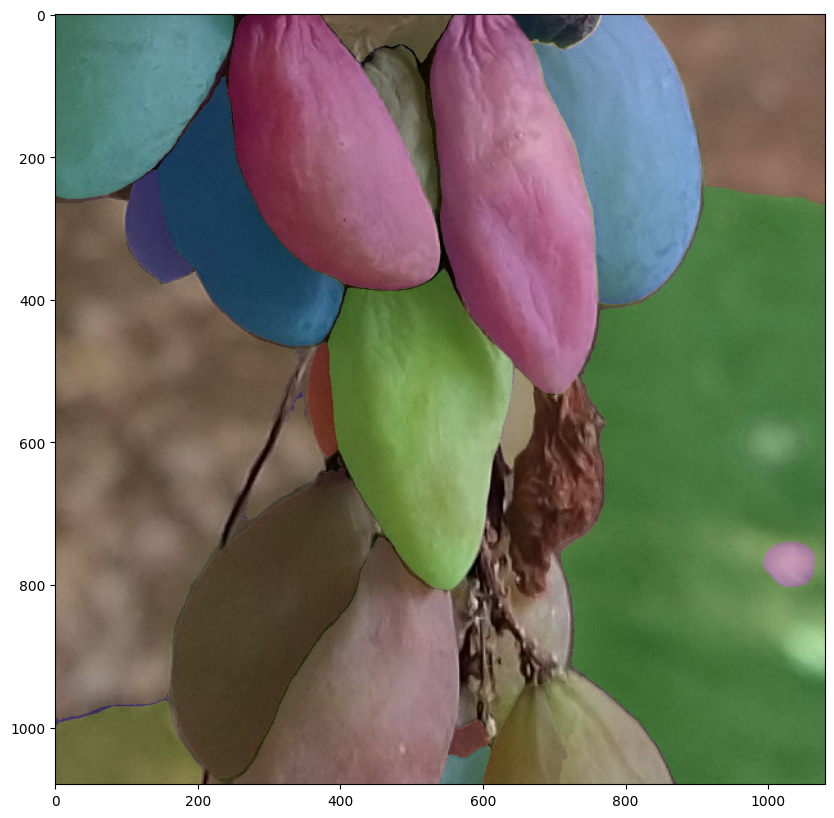

Maschere trovate:  28


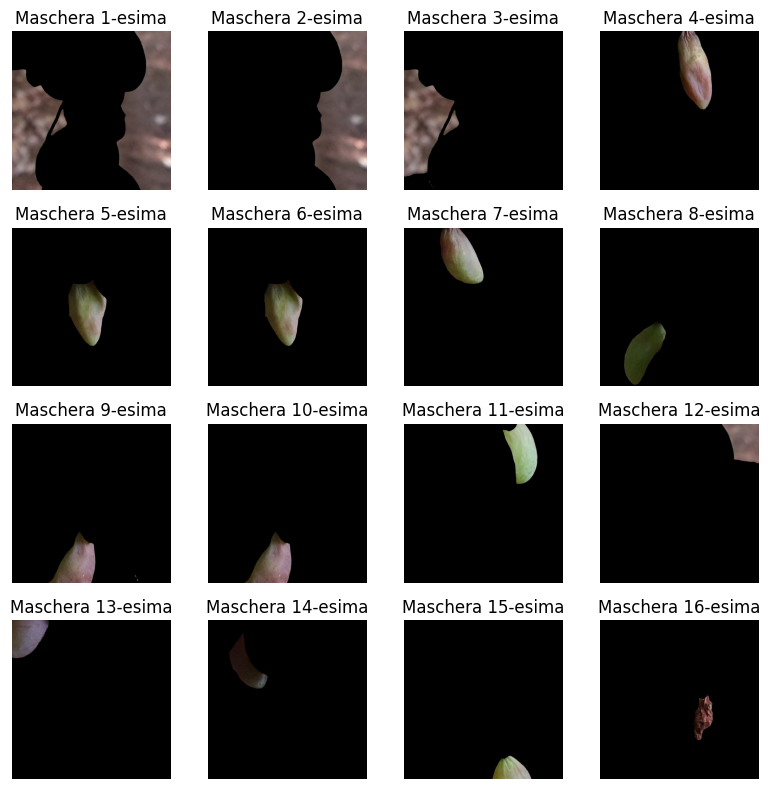

In [100]:
#Segmentazione degli acini cattivi e visualizzazione di quest'ultimi. Se manual_mode = True scegliere il numero dell'acino (o acini) che si vogliono utilizzare
#Se si vuole modificare più di un acino sano con lo stesso danneggiato inserire più volte il numero dell'acino danneggiato
bad_grape = load_and_bad_segmentation(immagine_cattiva, mask_generator_bad, 0)

good
Numero maschere predette prima del filtraggio per area:  151
Numero maschere rimanenti dopo il filtraggio per area:  148
Lunghezza maschera ordinata:  148
Numero randomico estratoo:  96
Numero randomico estratoo:  132
Numero randomico estratoo:  67
Numero randomico estratoo:  146
Numero randomico estratoo:  56
Numero randomico estratoo:  75
Numero randomico estratoo:  37
Numero randomico estratoo:  103
Numero randomico estratoo:  144
Numero randomico estratoo:  97
Numero randomico estratoo:  115


good
Numero maschere predette prima del filtraggio per area:  166
Numero maschere rimanenti dopo il filtraggio per area:  166
Lunghezza maschera ordinata:  166
Numero randomico estratoo:  40
Numero randomico estratoo:  55
Numero randomico estratoo:  145
Numero randomico estratoo:  110
Numero randomico estratoo:  90
Numero randomico estratoo:  94
Numero randomico estratoo:  146
Numero randomico estratoo:  47
Numero randomico estratoo:  137
Numero randomico estratoo:  148
Numero randomico estratoo:  30


good
Numero maschere predette prima del filtraggio per area:  165
Numero maschere rimanenti dopo il filtraggio per area:  165
Lunghezza maschera ordinata:  165
Numero randomico estratoo:  40
Numero randomico estratoo:  146
Numero randomico estratoo:  23
Numero randomico estratoo:  121
Numero randomico estratoo:  124
Numero randomico estratoo:  162
Numero randomico estratoo:  106
Numero randomico estratoo:  81
Numero randomico estratoo:  115
Numero randomico estratoo:  145
Numero randomico estratoo:  94


good
Numero maschere predette prima del filtraggio per area:  123
Numero maschere rimanenti dopo il filtraggio per area:  118
Lunghezza maschera ordinata:  118
Numero randomico estratoo:  39
Numero randomico estratoo:  37
Numero randomico estratoo:  1
Numero randomico estratoo:  36
Numero randomico estratoo:  100
Numero randomico estratoo:  19
Numero randomico estratoo:  40
Numero randomico estratoo:  57
Numero randomico estratoo:  102
Numero randomico estratoo:  76
Numero randomico estratoo:  44


good
Numero maschere predette prima del filtraggio per area:  150
Numero maschere rimanenti dopo il filtraggio per area:  147
Lunghezza maschera ordinata:  147
Numero randomico estratoo:  21
Numero randomico estratoo:  69
Numero randomico estratoo:  19
Numero randomico estratoo:  123
Numero randomico estratoo:  71
Numero randomico estratoo:  9
Numero randomico estratoo:  37
Numero randomico estratoo:  50
Numero randomico estratoo:  11
Numero randomico estratoo:  58
Numero randomico estratoo:  51


good
Numero maschere predette prima del filtraggio per area:  202
Numero maschere rimanenti dopo il filtraggio per area:  201
Lunghezza maschera ordinata:  201
Numero randomico estratoo:  7
Numero randomico estratoo:  78
Numero randomico estratoo:  60
Numero randomico estratoo:  106
Numero randomico estratoo:  114
Numero randomico estratoo:  6
Numero randomico estratoo:  82
Numero randomico estratoo:  152
Numero randomico estratoo:  27
Numero randomico estratoo:  103
Numero randomico estratoo:  139


good
Numero maschere predette prima del filtraggio per area:  151
Numero maschere rimanenti dopo il filtraggio per area:  150
Lunghezza maschera ordinata:  150
Numero randomico estratoo:  131
Numero randomico estratoo:  30
Numero randomico estratoo:  149
Numero randomico estratoo:  29
Numero randomico estratoo:  41
Numero randomico estratoo:  52
Numero randomico estratoo:  103
Numero randomico estratoo:  50
Numero randomico estratoo:  109
Numero randomico estratoo:  97
Numero randomico estratoo:  80


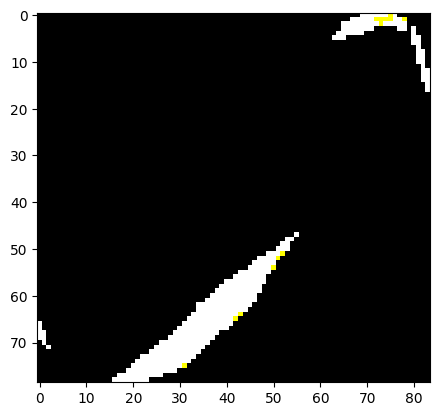

In [148]:
choice_list = [7, 7, 4, 4, 6, 6, 4, 4, 7, 8, 8]
main(choice_list, mask_generator_good, immagine_cattiva, good_grapes_dir, lista_img, bad_grape, generate_grapes, "thirdtime")

In [ ]:
from google.colab import files
!zip -r /content/new_grapes.zip /content/new_grapes
files.download("/content/new_grapes.zip")